# Import Packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image as Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cuda')

# Load the Data

In [4]:
train_path = '../input/hindiocr/training/training'

In [5]:
real_images_ = os.listdir(f'{train_path}/hi')
real_images = []
for i in real_images_:
    real_images.append('hi/'+i) 
    
fake_images_ = os.listdir(f'{train_path}/background')
fake_images = []
for i in fake_images_:
    fake_images.append('background/'+i)  

In [6]:
print(f'No.of.Real images: {len(real_images)}')
print(f'No.of.Fake images: {len(fake_images)}')

No.of.Real images: 1425
No.of.Fake images: 4450


In [7]:
real_labels = np.ones(len(real_images)) #Contains ones
fake_labels = np.zeros(len(fake_images)) #Contains zeros

In [8]:
Images = real_images + fake_images
Labels = np.concatenate((real_labels,fake_labels))

In [9]:
train_df = pd.DataFrame({'Images':Images,'Labels':Labels})

In [10]:
train_df = train_df.sample(frac=1)

In [11]:
train_df.head()

,Images,Labels
1714,background/envelope_18_flip_blur_d3.jpg,0.0
2299,background/displayPanel_1_rotate_sharpen_d2.jpg,0.0
3880,background/envelope_16_rotate_none_d3.jpg,0.0
2041,background/door_0_none_sharpen_d3.jpg,0.0
2934,background/fabric_5_none_edgeEnhance.jpg,0.0


In [12]:
print(f'No.of.Trainining samples: {len(train_df)}')

No.of.Trainining samples: 5875


In [13]:
class ImageDataset(Dataset):
    
    def __init__(self,path,df,image_transforms,train=True):
        self.path = path
        self.df = df
        self.image_transforms = image_transforms
        self.train = train
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        img = Image.open(f'{self.path}/{self.df.iloc[idx,0]}')
        if self.image_transforms:
            img = self.image_transforms(img)
        if self.train:
            label = self.df.iloc[idx,1]
            return img,label
        return img                

In [14]:
image_transforms = transforms.Compose([transforms.ToTensor()])

In [15]:
dataset = ImageDataset(train_path,train_df,image_transforms)

In [16]:
sample = int(np.random.randint(1,5375,(1,)))
img,label = dataset[sample]
img = img.numpy()
img = np.transpose(img,(1,2,0))

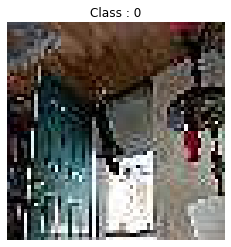

In [17]:
plt.imshow(img)
plt.title(f'Class : {label:.0f}')
plt.axis('off')
plt.show()

In [18]:
train_set,valid_set = torch.utils.data.random_split(dataset,[5375,500])

In [19]:
train_dataloader = DataLoader(train_set,batch_size=32,shuffle=True)
valid_dataloader = DataLoader(valid_set,batch_size=32,shuffle=False)

# Create the Model

In [20]:
model = models.vgg19(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

In [21]:
model.classifier = nn.Sequential(
                                   nn.Linear(25088,4096),
                                   nn.ReLU(inplace=True),
                                   nn.Dropout(0.5),
                                   nn.Linear(4096,4096),
                                   nn.ReLU(inplace=True),
                                   nn.Dropout(0.5),
                                   nn.Linear(4096,1000),
                                   nn.ReLU(inplace=True),
                                   nn.Linear(1000,512),
                                   nn.ReLU(inplace=True),
                                   nn.Linear(512,1),
                                   nn.Sigmoid()
                                )

In [22]:
model = model.to(device)

In [23]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

# Train/Validate Functions

In [24]:
def train(dataloader,model,loss_fn,optimizer):
    
    model.train()
    
    correct = 0
    total = 0
    running_loss = 0
    
    for batch,(imgs,labels) in enumerate(dataloader):
        
        output = model(imgs.to(device))
        loss = loss_fn(output.view(-1),labels.type(torch.FloatTensor).to(device))
        running_loss += loss.item()
        
        total += imgs.size(0)
        preds = output.view(-1).cpu()
        correct += ((preds>0.5).float() == labels.cpu()).sum().item() 
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    avg_loss = running_loss/len(dataloader)
    print(f'Training Loss: {avg_loss:.7f}',end='\t')
    print(f'Accuracy on Training set: {100*(correct/total)}% [{correct}/{total}]')

In [25]:
def validate(dataloader,model,loss_fn):
    model.eval() #Sets the model for evaluation.
    
    total = 0
    correct = 0
    running_loss = 0
    
    with torch.no_grad(): #No need to calculate the gradients.
        
        for x,y in dataloader:
            
            output        = model(x.to(device)) #model's output.
            loss          = loss_fn(output.view(-1),y.type(torch.FloatTensor).to(device)).item() #loss calculation.
            running_loss += loss
            
            total        += y.size(0)
            preds   = output.view(-1).cpu()
            correct      += ((preds>0.5).float() == y.cpu()).sum().item()
            
    avg_loss = running_loss/len(dataloader) #Average loss per batch.      
    
    print(f'\nValidation Loss = {avg_loss:.7f}',end='\t')
    print(f'Accuracy on Validation set = {100*(correct/total):.7f}% [{correct}/{total}]') #Prints the Accuracy.
    
    return avg_loss

# Optimize the Model

In [26]:
def optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs):
    train_losses = []
    valid_losses = []

    for epoch in range(nb_epochs):
        print(f'\nEpoch {epoch+1}/{nb_epochs}')
        print('-------------------------------')
        train_loss = train(train_dataloader,model,loss_fn,optimizer) #Calls the train function.
        train_losses.append(train_loss)
        valid_loss = validate(valid_dataloader,model,loss_fn) #Calls the validate function.
        valid_losses.append(valid_loss)
    
    print('\nTraining has completed!')
    
    return train_losses,valid_losses

In [27]:
loss_fn   = nn.BCELoss() #CrossEntropyLoss with class_weights.
optimizer = torch.optim.SGD(model.parameters(),lr=0.001) 
nb_epochs = 25
#Call the optimize function.
train_losses, valid_losses = optimize(train_dataloader,valid_dataloader,model,loss_fn,optimizer,nb_epochs)


Epoch 1/25
-------------------------------
Training Loss: 0.6658237	Accuracy on Training set: 75.86976744186047% [4078/5375]

Validation Loss = 0.6558240	Accuracy on Validation set = 74.6000000% [373/500]

Epoch 2/25
-------------------------------
Training Loss: 0.6362115	Accuracy on Training set: 75.85116279069769% [4077/5375]

Validation Loss = 0.6257593	Accuracy on Validation set = 74.6000000% [373/500]

Epoch 3/25
-------------------------------
Training Loss: 0.5897182	Accuracy on Training set: 75.85116279069769% [4077/5375]

Validation Loss = 0.5676712	Accuracy on Validation set = 74.6000000% [373/500]

Epoch 4/25
-------------------------------
Training Loss: 0.5383882	Accuracy on Training set: 75.85116279069769% [4077/5375]

Validation Loss = 0.5325964	Accuracy on Validation set = 74.6000000% [373/500]

Epoch 5/25
-------------------------------
Training Loss: 0.5011001	Accuracy on Training set: 75.85116279069769% [4077/5375]

Validation Loss = 0.4937266	Accuracy on Validatio

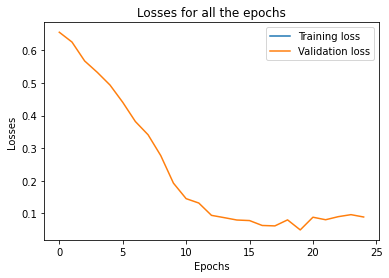

In [28]:
plt.title('Losses for all the epochs')
plt.plot(train_losses,label='Training loss')
plt.plot(valid_losses,label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Losses')
plt.legend()
plt.show()

# Testing the Model

In [29]:
test_path = '../input/hindiocr/test/test'

In [30]:
test_images = os.listdir(test_path)

In [31]:
test_df = pd.DataFrame({'Images':test_images})

In [32]:
test_set = ImageDataset(test_path,test_df,image_transforms,train=False)

In [33]:
test_dataloader = DataLoader(test_set,batch_size=32,shuffle=False)

In [34]:
def test(dataloader,model):
    model.eval() #Sets the model for evaluation.
    
    labels = [] #List to store the predicted labels.
    
    with torch.no_grad():
        
        for batch,x in enumerate(dataloader):
            
            output = model(x.to(device))
            
            predictions = output.argmax(dim=1).cpu().detach().tolist() #Predicted labels for an image batch.
            labels.extend(predictions)
                
    print('Testing has completed')
            
    return labels

In [35]:
labels = test(test_dataloader,model)

Testing has completed


In [36]:
test_df['Labels'] = labels

In [37]:
test_df.head()

,Images,Labels
0,45.jpg,0
1,56.jpg,0
2,89.jpg,0
3,20.jpg,0
4,58.jpg,0


In [38]:
import random
import json

def write_json(filename, result):
    with open(filename, 'w') as outfile:
        json.dump(result, outfile)

def read_json(filename):
    with open(filename, 'r') as outfile:
        data =  json.load(outfile)
    return data

def generate_file(filename):
    res = {}
    for i in range(1,99):
        test_file = str(i) + '.jpg'
        temp = test_df[test_df['Images']== test_file] 
        res[test_file] = int(temp['Labels'])

    write_json(filename, res)

In [39]:
generate_file('result.json')

In [40]:
test_results = read_json('result.json')

In [41]:
test_results

{'1.jpg': 0,
 '2.jpg': 0,
 '3.jpg': 0,
 '4.jpg': 0,
 '5.jpg': 0,
 '6.jpg': 0,
 '7.jpg': 0,
 '8.jpg': 0,
 '9.jpg': 0,
 '10.jpg': 0,
 '11.jpg': 0,
 '12.jpg': 0,
 '13.jpg': 0,
 '14.jpg': 0,
 '15.jpg': 0,
 '16.jpg': 0,
 '17.jpg': 0,
 '18.jpg': 0,
 '19.jpg': 0,
 '20.jpg': 0,
 '21.jpg': 0,
 '22.jpg': 0,
 '23.jpg': 0,
 '24.jpg': 0,
 '25.jpg': 0,
 '26.jpg': 0,
 '27.jpg': 0,
 '28.jpg': 0,
 '29.jpg': 0,
 '30.jpg': 0,
 '31.jpg': 0,
 '32.jpg': 0,
 '33.jpg': 0,
 '34.jpg': 0,
 '35.jpg': 0,
 '36.jpg': 0,
 '37.jpg': 0,
 '38.jpg': 0,
 '39.jpg': 0,
 '40.jpg': 0,
 '41.jpg': 0,
 '42.jpg': 0,
 '43.jpg': 0,
 '44.jpg': 0,
 '45.jpg': 0,
 '46.jpg': 0,
 '47.jpg': 0,
 '48.jpg': 0,
 '49.jpg': 0,
 '50.jpg': 0,
 '51.jpg': 0,
 '52.jpg': 0,
 '53.jpg': 0,
 '54.jpg': 0,
 '55.jpg': 0,
 '56.jpg': 0,
 '57.jpg': 0,
 '58.jpg': 0,
 '59.jpg': 0,
 '60.jpg': 0,
 '61.jpg': 0,
 '62.jpg': 0,
 '63.jpg': 0,
 '64.jpg': 0,
 '65.jpg': 0,
 '66.jpg': 0,
 '67.jpg': 0,
 '68.jpg': 0,
 '69.jpg': 0,
 '70.jpg': 0,
 '71.jpg': 0,
 '72.jpg': 0,
 